In [1]:
from scipy.io import wavfile
from icecream import ic
import matplotlib.pyplot as plt
import numpy as np
import tqdm
from scipy.fft import rfft, rfftfreq
from scipy.signal import decimate, butter, lfilter, correlate
from scipy.integrate import quad
from scipy.interpolate import interp1d

In [2]:
def parabolic(f, x):
    xv = 1/2. * (f[x-1] - f[x+1]) / (f[x-1] - 2 * f[x] + f[x+1]) + x
    yv = f[x] - 1/4. * (f[x-1] - f[x+1]) * (xv - x)
    return (xv, yv)

def freq_from_autocorr(sig, fs):
    """
    Estimate frequency using autocorrelation
    """
    corr = correlate(sig, sig, mode='full')
    corr = corr[len(corr)//2:]
    d = np.diff(corr)
    start = np.nonzero(d > 0)[0][0]
    peak = np.argmax(corr[start:]) + start
    px, py = parabolic(corr, peak)

    return fs / px

In [3]:
def integrate_area(x, y, a, b):
    # Create linear interpolation function for the curve
    f = interp1d(x, y, kind='linear', fill_value='extrapolate')
    
    # Perform numerical integration between a and b
    area, _ = quad(f, a, b)
    return area

In [4]:
# Reference https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

ic| data: array([ -8,   6, -11, ...,   0,  -1,   2], shape=(10000,), dtype=int16)
ic| np.mean(data): np.float64(-0.396)
ic| data: array([ -7.604,   6.396, -10.604, ...,   0.396,  -0.604,   2.396],
                shape=(10000,))
ic| np.mean(data): np.float64(4.320099833421409e-16)


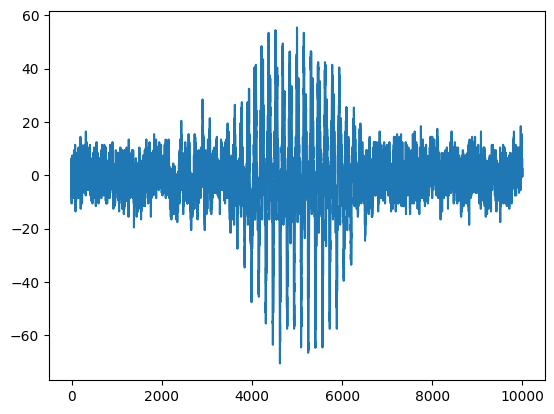

In [5]:
waveform_path = '/home/aubrey/Desktop/wingbeat-recorder/example_waveforms/2025-04-19T14:46:23.649496+08:00.wav'
sr, data = wavfile.read(waveform_path)
ic(data)
ic(np.mean(data))
data = data - np.mean(data)  # Remove DC offset; note that data.dtype converts from int(16) to float(32)
ic(data)
ic(np.mean(data))
plt.plot(data);

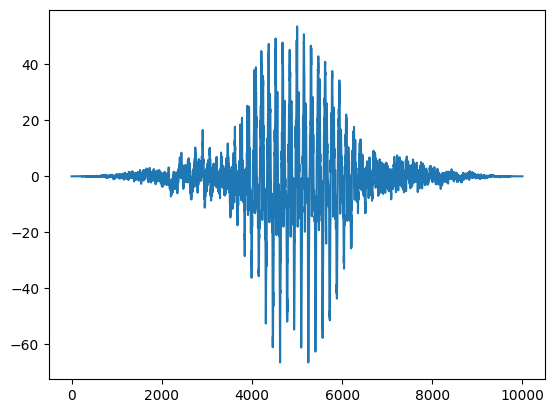

In [6]:
sr, data = wavfile.read(waveform_path)

#apply bandpass filter
data = butter_bandpass_filter(data, lowcut=20, highcut=10000, fs=sr, order=5)

# remove DC offset
data = data - np.mean(data)  # Remove DC offset; note that data.dtype converts from int(16) to float(32)

# apply Hanning window
data = np.hanning(data.shape[0]) * data

plt.plot(data)

In [7]:

# Perform FFT and calculate frequency array
power = np.abs(rfft(data))
freq = rfftfreq(data.shape[0], 1/sr)
ic(freq)

# Normalize so that the area under the curve is 1
power = power / integrate_area(freq, power, freq[0], freq[-1])
ic(np.sum(power))
ic(integrate_area(freq, power, freq[0], freq[-1]))

ic| freq: array([0.00000e+00, 4.80000e+00, 9.60000e+00, ..., 2.39904e+04,
                 2.39952e+04, 2.40000e+04], shape=(5001,))
/tmp/ipykernel_855888/3581546301.py:6: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  area, _ = quad(f, a, b)
ic| np.sum(power): np.float64(0.20677807499561335)
ic| integrate_area(freq, power, freq[0], freq[-1]): 0.9999999999999998


0.9999999999999998

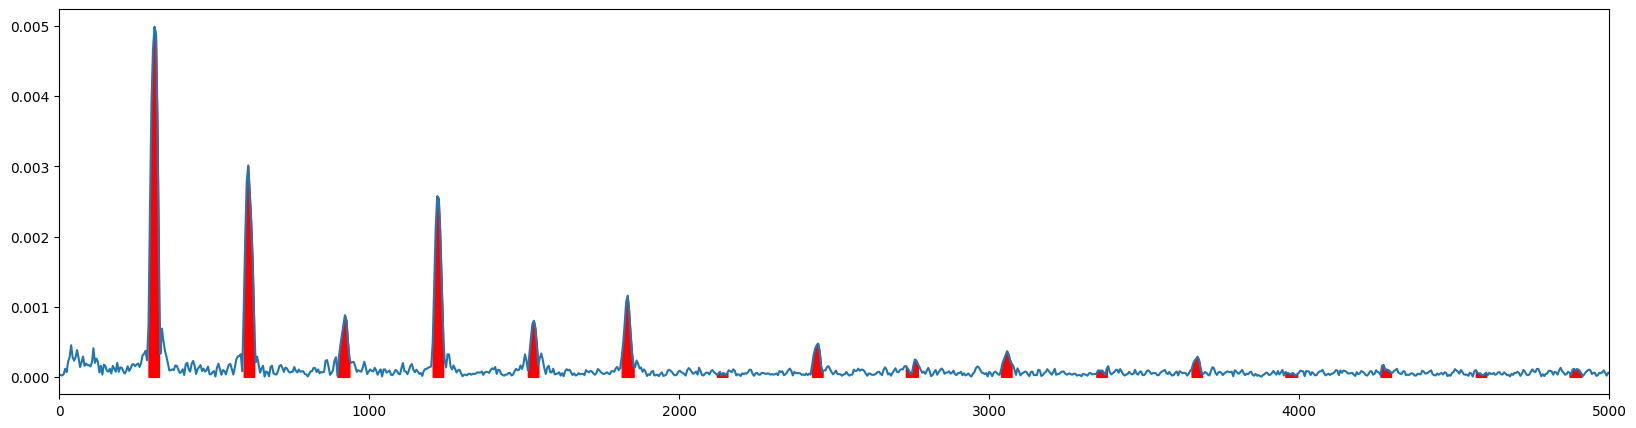

In [14]:
from matplotlib.patches import Rectangle

mywidth = 40

wingbeat_frequency = freq_from_autocorr(data, fs=sr)

# Plot the FFT result
fig = plt.figure(figsize=(20, 5))
plt.plot(freq, power)

# plt.stem(freq, power, markerfmt=' ')
plt.xlim(0, 5000)

for i in range(20):
    harmonic = wingbeat_frequency * (i + 1)
    
    #Fill area under the curve
    plt.fill_between(
            x= freq, 
            y1= power, 
            where= (harmonic-mywidth/2 <= freq) & (freq <= harmonic+mywidth/2),
            color= "red",
            )
    
    

# Downsample factor 8

In [9]:
# ic(waveform_path)
# sr, data = wavfile.read(waveform_path)
# ic(type(sr))
# ic(sr);
# ic(data)

# downsample_factor = 8
# data = data[::downsample_factor]
# sr = sr // downsample_factor
# ic(type(sr))
# ic(sr)
# ic(data)

# plt.plot(data)

# wavfile.write('downsampled.wav', sr, data)

In [10]:
# sr, data = wavfile.read(waveform_path)

# #apply bandpass filter
# data = butter_bandpass_filter(data, lowcut=20, highcut=10000, fs=sr, order=5)

# # remove DC offset
# data = data - np.mean(data)  # Remove DC offset; note that data.dtype converts from int(16) to float(32)

# # apply Hanning window
# data = np.hanning(data.shape[0]) * data

# plt.plot(data)

In [11]:
# # Perform FFT and calculate frequency array
# power = np.abs(rfft(data))
# freq = rfftfreq(data.shape[0], 1/sr)
# ic(freq)

# # Plot the FFT result
# plt.stem(freq, power, markerfmt=' ')
# plt.xlim(0, 5000)